<a href="https://colab.research.google.com/github/muffin-head/GANs_AutoEncoders/blob/main/GANS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
from tensorflow.keras.layers import Input, Dense, Lambda # lamda is used for custom operations
from tensorflow.keras.models import Model
from tensorflow.keras import backend as k # backend is more connecting keras to theano or TF functionality
from tensorflow.keras.datasets import mnist
import numpy as np
import tensorflow as tf
from tensorflow.keras import metrics



#  Orignal image dim is 28x28, so flatten it i.e 784 (28x28) we have single intermediate layer as well we can have value, lets say 256(its hyper param)

In [36]:
batch_size= 100
orignal_dim= 28*28
latent_dim= 2     # compression of 28x28 to 2x2 dimension from which reconstruction will happen, its final o/p of encoder
Intermediate_dim= 256  #layer in which the input image i.e 28x28 i.e 784 is compressed and then passed to latent
nb_epoch=50
epsilon_std=1.0 # noise to be added






1) k.shape(z_mean)[0] --> how dense layer works is its: Its the weighted sum of the input, lets assume the dense layer is 348 and next dense layer is 2(latent one) so it will do the weighted sum of it and pass it and so the dim will be [weighted sum, 2] same for another remaining neuron as well, so to main the shape in sampling we use shape that takes 1st object i.e the batch size of vector and latent dim.

k.exp(z_log_var/2) * epsilon --> This is nothing but the noise and adding mean to it


Basically we sample frokm this districution and feed these values to the decoder.


In [37]:
def sampling(args:tuple):
  z_mean,z_log_var=args
  epsilon=k.random_normal(shape=(k.shape(z_mean)[0],latent_dim),mean=0,stddev=epsilon_std)
  return z_mean+ k.exp(z_log_var/2) * epsilon

In [38]:
x= Input(shape=(orignal_dim,),name='input')
h=Dense(Intermediate_dim,activation='relu', name='encoding')(x)  #activation func: when the neurons to be activated, relu=if no. is pos= as it is , if no. neg= turns it to 0
z_mean = Dense(latent_dim, name='mean')(h) #Defines the mean of the latent space
z_log_var=Dense(latent_dim,name='log_var')(h) #defines the var of the latent space
# now i have mean and var layer above right!, I will take this both and put as input to lambda func, now sampling is the lambda function which will take random samples from the normal dist (from mean and var that we passed and give us output in dim of latemt dim itself)
z= Lambda(sampling,output_shape=(latent_dim,))([z_mean,z_log_var])
encoder=Model(x,[z_mean,z_log_var,z],name='encoder')

In [39]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 784)]                0         []                            
                                                                                                  
 encoding (Dense)            (None, 256)                  200960    ['input[0][0]']               
                                                                                                  
 mean (Dense)                (None, 2)                    514       ['encoding[0][0]']            
                                                                                                  
 log_var (Dense)             (None, 2)                    514       ['encoding[0][0]']            
                                                                                            

In [40]:
input_decoder=Input(shape=(latent_dim,),name='decoder_input')
decoder_h=Dense(Intermediate_dim,activation='relu',name='decoder_h')(input_decoder)
x_decoded=Dense(orignal_dim,activation='sigmoid',name='flattened_decoded_h')(decoder_h)
decoder=Model(input_decoder,x_decoded,name='decoder')

In [41]:
output_model_combined= decoder(encoder(x)[2])
vae=Model(x,output_model_combined)
vae.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               201988    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 404244 (1.54 MB)
Trainable params: 404244 (1.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
def vae_loss(x: tf.Tensor, x_decoded_mean: tf.Tensor,
            z_log_var=z_log_var, z_mean=z_mean,
            original_dim=orignal_dim):
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * k.mean ( 1 + z_log_var - k.square(z_mean) - k.exp(z_log_var), axis=-1)
    vae_loss = k.mean(xent_loss + kl_loss)
    return vae_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               201988    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 404244 (1.54 MB)
Trainable params: 404244 (1.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



# Train test split the dat aand divide the data by 255 to normalize the data between 0-1 as 0 represensts black and 255 as white so working onn thiws will be unstable

In [43]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


In [44]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=nb_epoch,
        batch_size=batch_size)

Train on 60000 samples
Epoch 1/50
60000/60000 [==============================] - 5s 76us/sample - loss: 185.1096
Epoch 2/50
60000/60000 [==============================] - 5s 79us/sample - loss: 166.2593
Epoch 3/50
60000/60000 [==============================] - 4s 69us/sample - loss: 163.0997
Epoch 4/50
60000/60000 [==============================] - 4s 75us/sample - loss: 160.7289
Epoch 5/50
60000/60000 [==============================] - 4s 71us/sample - loss: 158.8245
Epoch 6/50
60000/60000 [==============================] - 4s 74us/sample - loss: 157.2627
Epoch 7/50
60000/60000 [==============================] - 5s 90us/sample - loss: 156.0314
Epoch 8/50
60000/60000 [==============================] - 4s 68us/sample - loss: 155.0769
Epoch 9/50
60000/60000 [==============================] - 4s 68us/sample - loss: 154.3065
Epoch 10/50
60000/60000 [==============================] - 5s 78us/sample - loss: 153.6814
Epoch 11/50
60000/60000 [==============================] - 4s 69us/sample - 

In [35]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

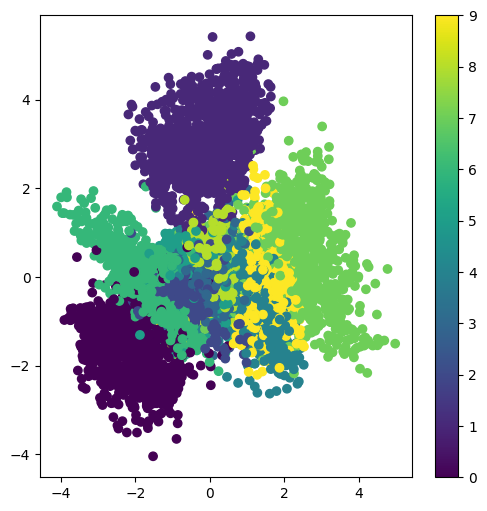

In [46]:
import matplotlib.pyplot as plt
from scipy.stats import norm
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

# Sampling in Latent Space: The code starts by defining a grid of points in the latent space. These points are generated using the inverse cumulative distribution function (ppf) of a Gaussian distribution. This grid represents different positions in the latent space.
# Decoding: For each point in the grid, the code does the following:

# It takes a point (xi, yi) from the grid, representing a specific location in the latent space.
# It creates a 2D array z_sample with the values (xi, yi).
# The z_sample is then passed to the decoder model (decoder) of the VAE.
# Decoder Model: The decoder model takes the z_sample as input and processes it. The decoder has learned to transform points in the latent space back into digit images. It decodes the z_sample into a digit image.

#Digit Image Reshaping: The decoded image is reshaped into a 28x28 pixel format. This is necessary because in the latent space, the points don't represent pixel values directly. They represent the latent features of the image.

#Adding to Grid: The reshaped digit image is placed in the figure array at the corresponding location within the grid. This process is repeated for each point in the grid.

#Visualization: Once all the points have been processed, the figure array contains a grid of digit images, each generated by sampling from a different location in the latent space.

# Display: The code uses the matplotlib library to display the grid of digit images as a single image. The grid provides a visualization of how the VAE model has learned to map different points in the latent space to meaningful digit images.

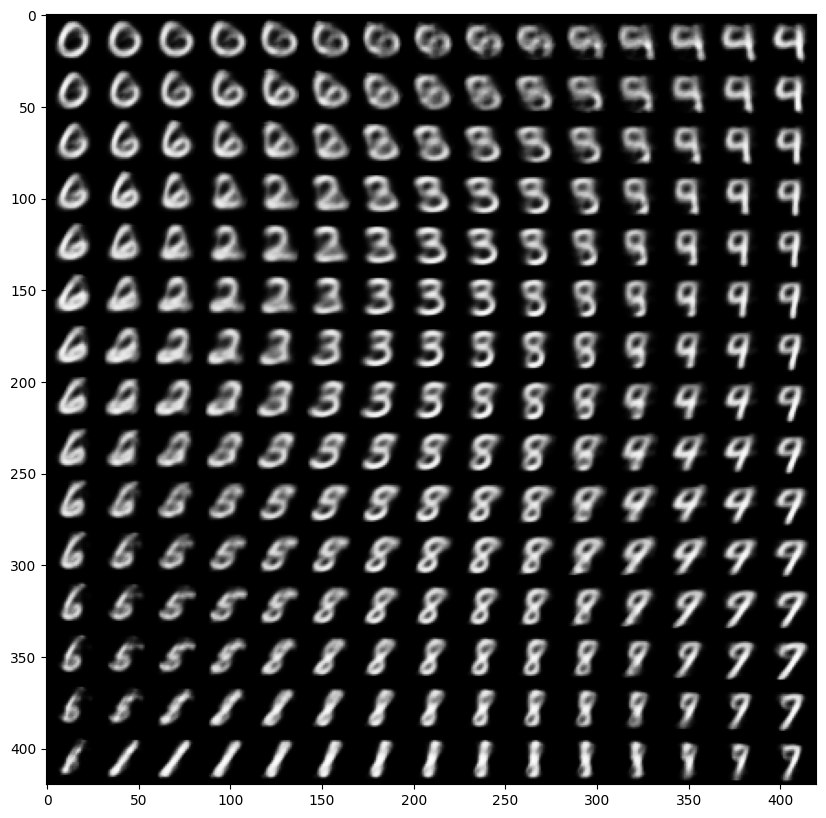

In [47]:
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()